# 코로나 확진자 예측해보기


In [20]:
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt

# Load the data
df = pd.read_excel("Covid19.xlsx")

df


,Date,Total,Daily
0,2020-01-22,1,1
1,2020-01-23,1,0
2,2020-01-24,2,1
3,2020-01-25,2,0
4,2020-01-26,3,1
...,...,...,...
1097,2023-01-23,30021018,12262
1098,2023-01-24,30040556,19538
1099,2023-01-25,30075652,35096
1100,2023-01-26,30107363,31711


그래프화

<AxesSubplot:xlabel='Date'>

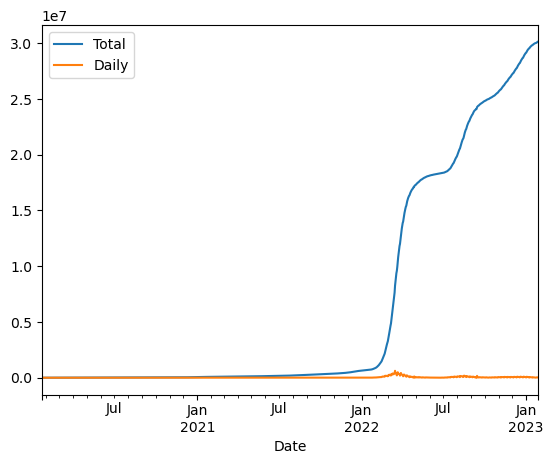

In [3]:
df.index = pd.to_datetime(df['Date'])

df.plot(x ='Date', y=['Total','Daily'], kind = 'line')


일일확진자만

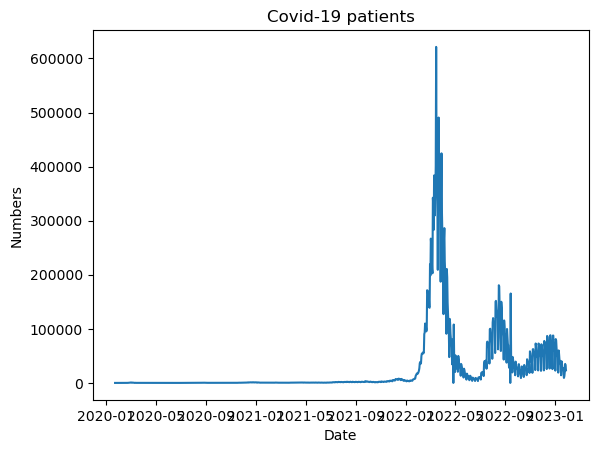

In [4]:
daily = df.Daily

plt.plot(daily)
plt.xlabel('Date')
plt.ylabel('Numbers')
plt.title('Covid-19 patients')
plt.show()

얼핏봐도 비정상성을 띄지만 그냥 진행

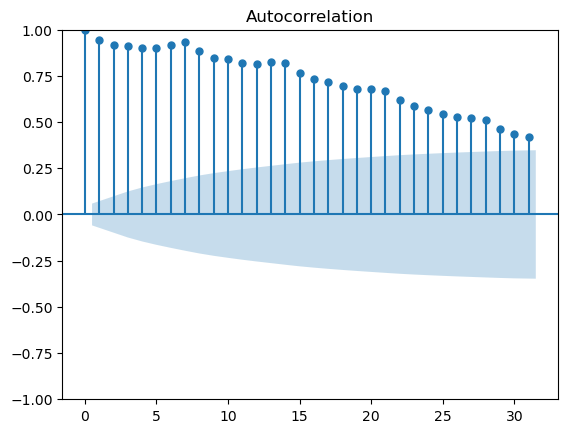

In [5]:
from statsmodels.tsa import stattools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

plot_acf(daily)
plt.show()

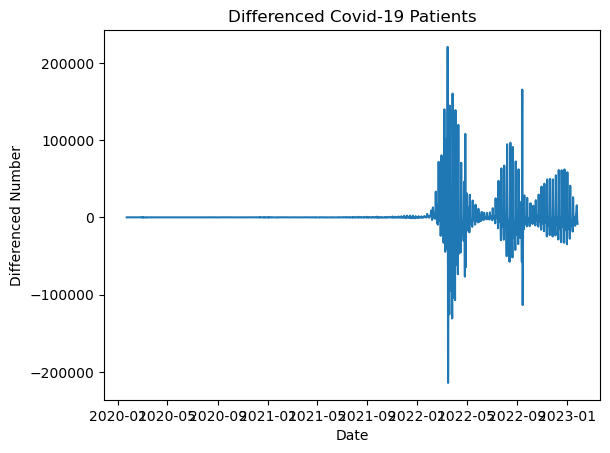

In [6]:
df['diff'] = df['Daily'].diff()

plt.plot(df['diff'])
plt.xlabel('Date')
plt.ylabel('Differenced Number')
plt.title('Differenced Covid-19 Patients')
plt.show()

너무 답이 없어보여서 최근 1년 데이터만 사용하기로 함

In [7]:
today = df.index[-1]

cutoff_date = today - pd.DateOffset(years=1)
df = df[df.index >= cutoff_date]

df

,Date,Total,Daily,diff
Date,,,,
2022-01-27,2022-01-27,793582,16085,1571.0
2022-01-28,2022-01-28,811122,17540,1455.0
2022-01-29,2022-01-29,828637,17515,-25.0
2022-01-30,2022-01-30,845709,17072,-443.0
2022-01-31,2022-01-31,864042,18333,1261.0
...,...,...,...,...
2023-01-23,2023-01-23,30021018,12262,3035.0
2023-01-24,2023-01-24,30040556,19538,7276.0
2023-01-25,2023-01-25,30075652,35096,15558.0


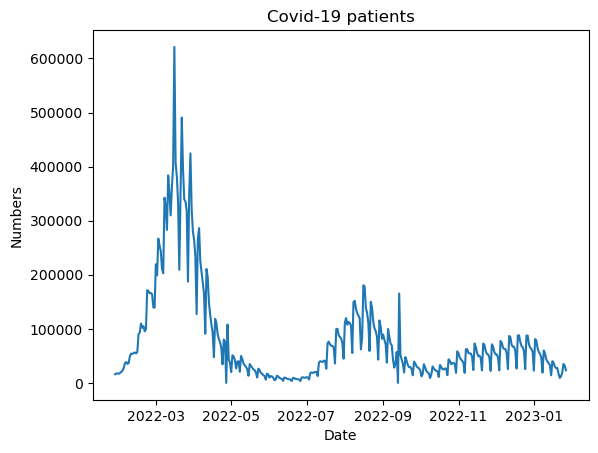

In [8]:
daily = df.Daily

plt.plot(daily)
plt.xlabel('Date')
plt.ylabel('Numbers')
plt.title('Covid-19 patients')
plt.show()

C:\Users\kkksk\AppData\Local\Temp\ipykernel_2284\403135870.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff'] = df['Daily'].diff()


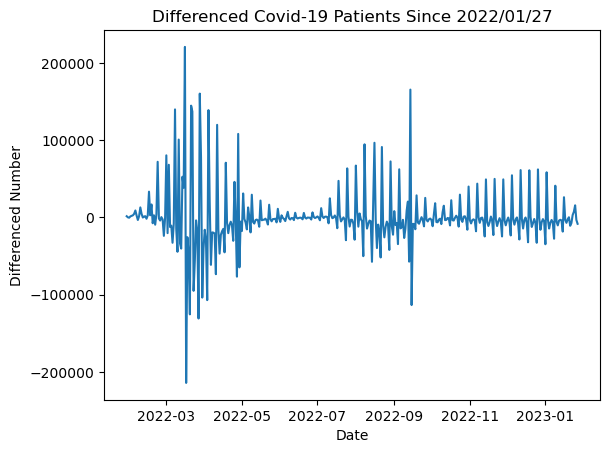

In [9]:
df['diff'] = df['Daily'].diff()

plt.plot(df['diff'])
plt.xlabel('Date')
plt.ylabel('Differenced Number')
plt.title('Differenced Covid-19 Patients Since 2022/01/27')
plt.show()

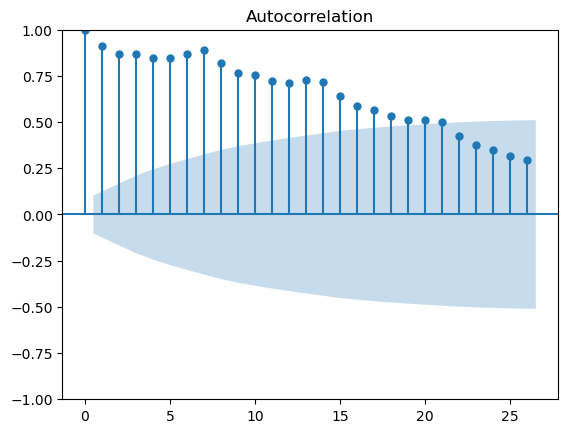

In [10]:
plot_acf(daily)
plt.show()

C:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


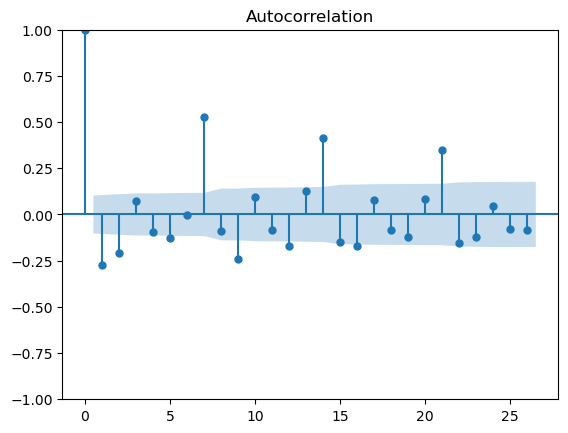

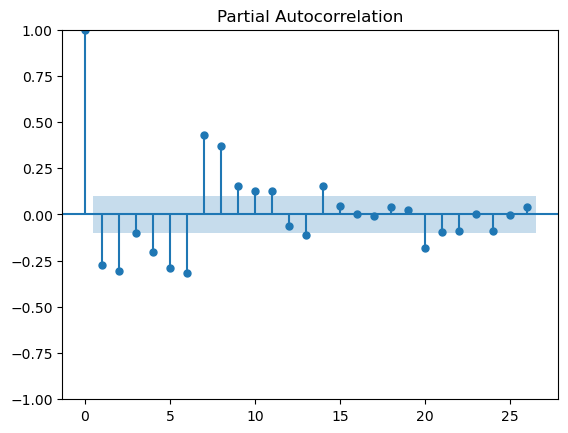

In [19]:
df = df.dropna(subset=['diff'])

plot_acf(df['diff'])
plot_pacf(df['diff'])

plt.show()


ADF Test로 정상성 갖는지 테스트

In [12]:
result=adfuller(df['diff'])

print(f'Test statistic: {result[0]}')
print(f'p-value: {result[1]}')

Test statistic: -2.9906559774390424
p-value: 0.03577627659650839


p-value가 0,05보다는 작아서 우선 정상성을 띄는 데이터로는 생각됨
하지만 acf, pacf가 유효범위를 많이 벗어나고 있음
자세히 확인해보면 7, 14, 21 등 7의 배수에서 유독 상관이 높은 것으로 나오는데,
이는 주말에 검사 수가 줄면서 확진자 수도 줄어드는 현상 때문인 것으로 추측됨.
따라서 계절성을 갖고 있는 것으로 보이기 때문에, SARIMA 모델을 사용하기로 함
우선 ARIMA (1,1,1) , SARIMA (0,1,1,7) 모델을 사용해봤음

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


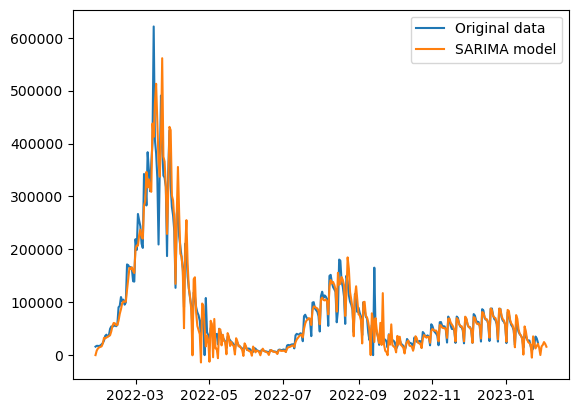

In [13]:
model = SARIMAX(daily, order=(1, 1, 1), seasonal_order=(0, 1, 1, 7))
model_fit = model.fit()

predictions = model_fit.predict(start=0, end=len(df['diff'])+7)

plt.plot(daily, label='Original data')
plt.plot(predictions, label='SARIMA model')

plt.legend()
plt.show()

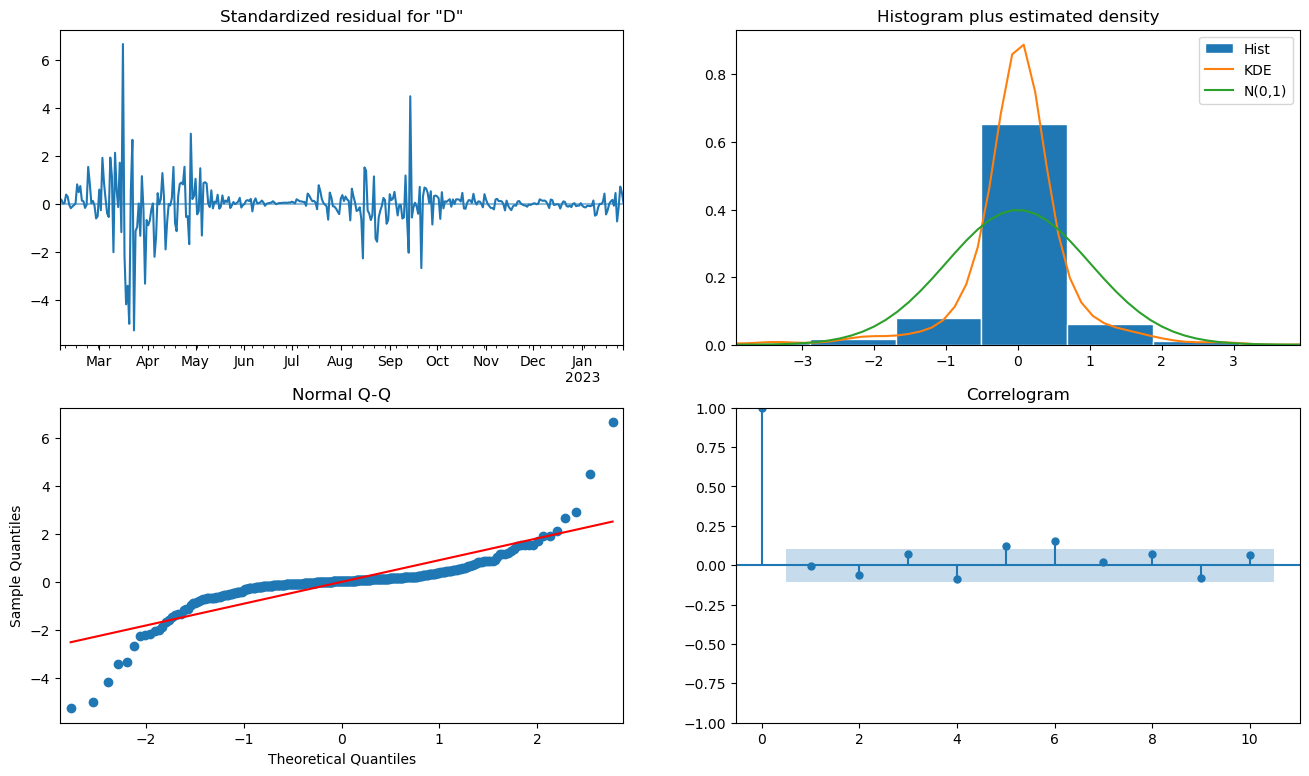

In [14]:
model.fit().plot_diagnostics(figsize = (16,9))
plt.show()

계수가 딱히 유의하지 않은것으로 나옴. 그래서 최적의 계수를 찾아보기로 함. 비교수치는 AIC.
밑의 코드는 실행하는데 오래 걸리므로 전체 주석처리함.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import itertools

warnings.filterwarnings("ignore") # to suppress warnings

p = d = q = range(0, 2) # parameter combinations for ARIMA model
pdq = list(itertools.product(p, d, q))

m = [7]
PDQ = list(itertools.product(range(0,2), range(0,2), range(0,2)))
PDQm = [(p,d,q,m[0]) for (p,d,q) in PDQ]

best_AIC = float("inf") # Initialize the best AIC score as infinity
best_params = None # Initialize the best parameters as None

for param in pdq:
    for param_seasonal in PDQm:
        try:
            mod = SARIMAX(daily,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            res = mod.fit()
            if res.aic < best_AIC:
                best_AIC = res.aic
                best_params = (param, param_seasonal)
        except:
            continue

print("Best ARIMA parameters: ", best_params[0])
print("Best SARIMA parameters: ", best_params[1])

최적의 계수가 ARIMA(0,1,1) SARIMA (1,1,1,7)로 나왔음
SARIMA의 m은 7일마다 확진자가 줄어드는 것이 명백하므로 7로 고정하고 코드를 돌렸음

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


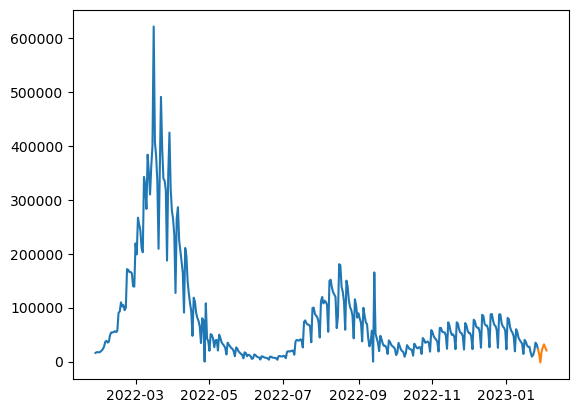

2023-01-27    22712.710555
2023-01-28    14023.872789
2023-01-29    -1616.039497
2023-01-30    18788.058855
2023-01-31    26426.838817
2023-02-01    31954.566041
2023-02-02    26418.787386
2023-02-03    20716.345868
Freq: D, Name: predicted_mean, dtype: float64


In [15]:
model = SARIMAX(daily, order=(0, 1, 1), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit()

predictions = model_fit.predict(start=len(df['diff']), end=len(df['diff'])+7)

plt.plot(daily, label='Original data')
plt.plot(predictions, label='SARIMA model')

plt.show()
print(predictions)

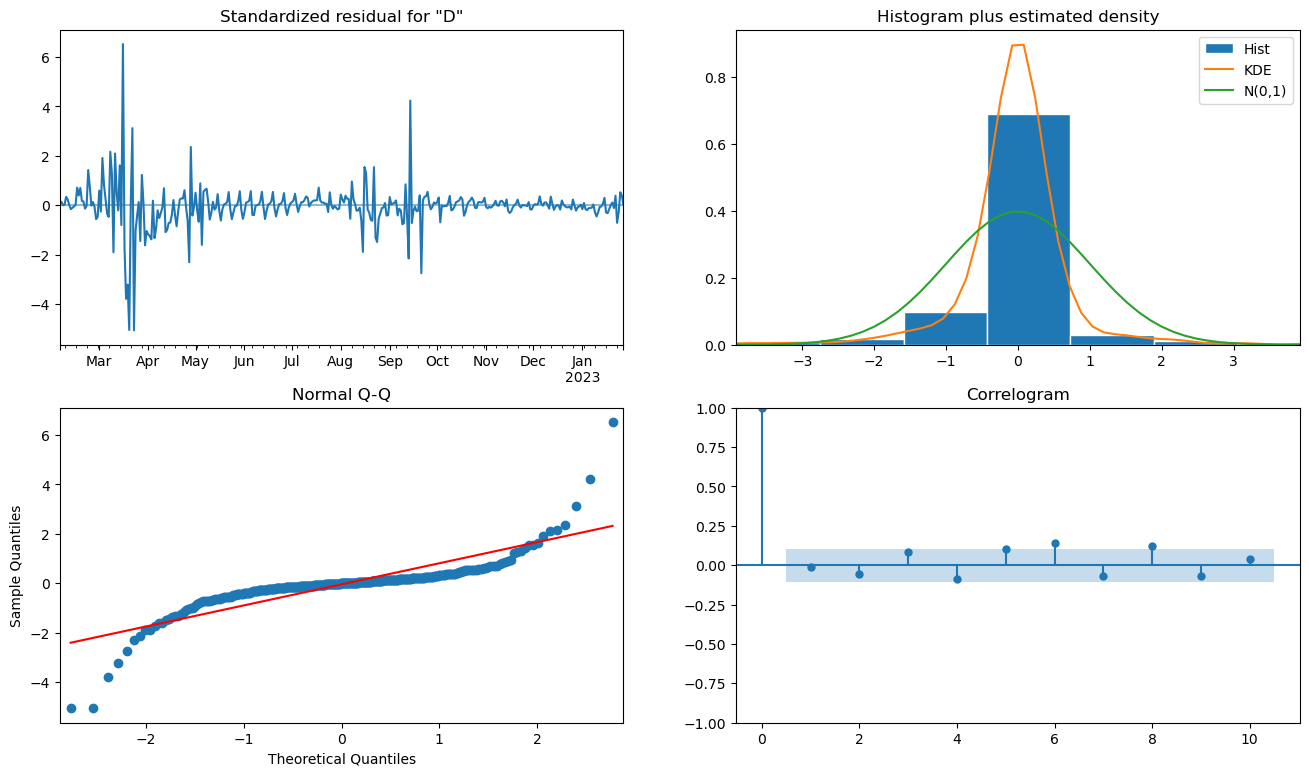

In [16]:
model.fit().plot_diagnostics(figsize = (16,9))
plt.show()

처음 했던 모델과 수치들이 크게 다르지 않아서 성능면에서 큰 차이는 없어보임 이는 ARIMA 모델을 여러 번 돌려본 결과를 보고 느낀 건데 계수가 1정도 바뀐다고 해서 모델의 성능이 크게 좋아지지는 않는 듯

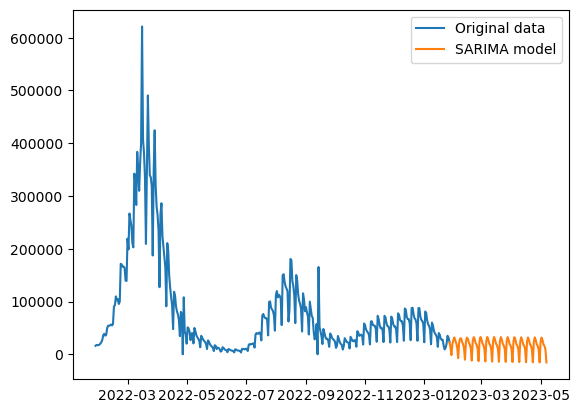

In [17]:
predictions = model_fit.predict(start=len(df['diff']), end=len(df['diff'])+100)

plt.plot(daily, label='Original data')
plt.plot(predictions, label='SARIMA model')

plt.legend()
plt.show()


ARIMA의 특징이 그렇게 먼 미래를 예측하는 것은 좋은 성과를 보이지 않는다는 것. 
이는 ARIMA 모델이 단순한 선형모델이라 어쩔 수 없다고 생각함.
그래서 좋게 추정하려면 주간 데이터로 모아보는 것이 어떨까 하고 생각하게 됨.